# Anomaly Detection

Sometimes we don't really know what we're looking for - we just know we want to make sure everything looks the same. For instance, if we are monitoring traffic to our website - we won't know HOW someone might try to attack us, we just want to identify any possible attacks. Or we won't know what a credit card holder is going to purchase, we just want to make sure it doesn't look like fraud. 

That means we're doing a special case of classification where we just want to identify outliers. This is sometimes called anomaly detection. There are lots of cool ways to go about this - it's a fascinating problem. We're just going to look at a few ways to do it. 

## Simple Covariance Models
Before we get started with SkLearn, let's look at some of the simplest methods.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
rng = np.random.RandomState(42)

Let's start by writing a class that draws a box around the data, using the mean and standard deviation in each direction as the guide for the box. We'll let the user specifiy how "tolerant" they want to be. This is the most naive approach we could take.

### Box Covariance

In [4]:
import numpy as np
import pandas as pd

class box_covariance:
    
    def __init__(self, threshold=1.): 
        """
        Builds a box envelope around the data using a
        standard deviation threshold. Any points within this
        box are considered inliers, and points outside of this
        box are considered outliers. This is a fairly simplistic
        method that is not very robust to highly correlated
        data with "close by" outliers.
        ---
        KWargs:
        threhsold: how many standard deviations do you want
        to consider an "inlier"
        """
        self.threshold = threshold
        self.data_stats = {}
        self.number_of_columns = None
        
    def fit(self, X):
        """
        Learns about the input data and stores the mean and 
        standard deviation of each column.
        ---
        In: X (features); np.array or pandas dataframe/series
        """
        X = self.convert_to_array(X)
        self.number_of_columns = X.shape[1]
        
        for ix in range(self.number_of_columns):
            col = X.T[ix]
            col_mean = np.mean(col)
            col_std = np.std(col)
            self.data_stats[ix] = (col_mean, col_std)
            
    def predict(self, X):
        """
        For each data point, subtract the mean of the column
        and then see if the data point is within 
        threshold*std_dev of that column of 0. If so, it's an
        inlier. Otherwise it's an outlier.
        """
        X = self.convert_to_array(X)
        result = np.ones(X.shape[0])
        for ix in range(self.number_of_columns):
            X.T[ix] = X.T[ix] - self.data_stats[ix][0]
            result[(result != -1) & (np.abs(X.T[ix]) >= self.data_stats[ix][1]*self.threshold)] = -1
        return result
    
    def fit_predict(self, X):
        """
        Learn from X and then return the transformed version
        of X for the user to use.
        ---
        In: X (features); np.array or pandas dataframe/series
        """
        self.fit(X)
        return self.predict(X)
    
    def pandas_to_numpy(self, x):
        """
        Checks if the input is a Dataframe or series, converts to numpy matrix for
        calculation purposes.
        ---
        Input: X (array, dataframe, or series)
        Output: X (array)
        """
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return x.as_matrix()
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x) 
    
    def handle_1d_data(self,x):
        """
        Converts 1 dimensional data into a series of rows with 1 columns
        instead of 1 row with many columns.
        """
        if x.ndim == 1:
            x = x.reshape(-1,1)
        return x
    
    def convert_to_array(self, x):
        """
        Takes in an input and converts it to a numpy array
        and then checks if it needs to be reshaped for us
        to use it properly
        """
        x = self.pandas_to_numpy(x)
        x = self.handle_1d_data(x)
        return x

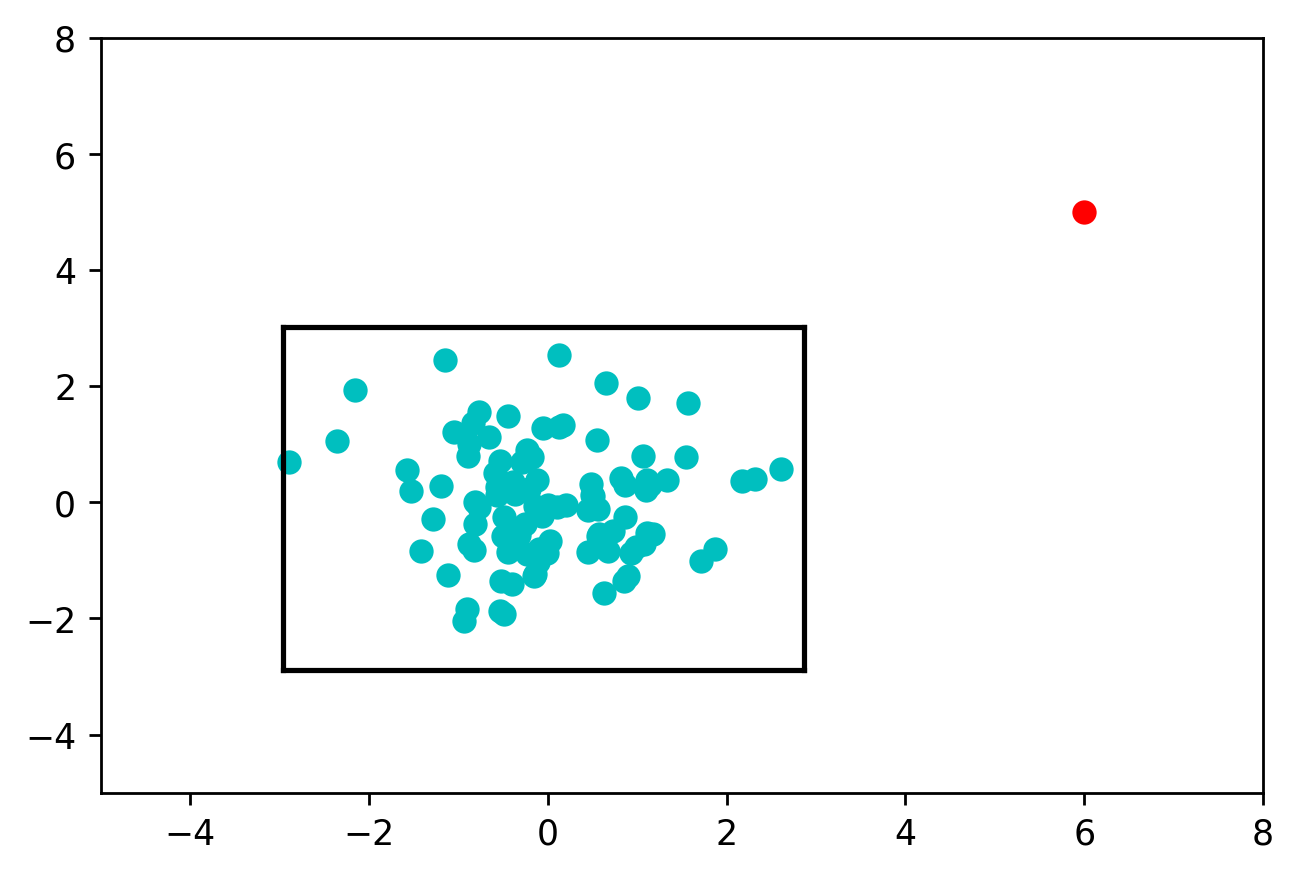

In [6]:
X = np.random.normal(0,1,size=(100,2))
outlier = np.array([6,6]).reshape(-1,2)
bc = box_covariance(threshold=3)
bc.fit(X)
plt.figure(dpi=250)
for pt,label in zip(X,bc.predict(X)):
    if label > 0:
        plt.scatter(pt[0], pt[1],c='c')
    else:
        plt.scatter(pt[0], pt[1],c='r') 
        
for pt,label in zip(outlier,bc.predict(outlier)):
    if label > 0:
        plt.scatter(pt[0], pt[1],c='c')
    else:
        plt.scatter(pt[0], pt[1],c='r')  
        
plt.xlim(-5,8)
plt.ylim(-5,8)
xlow = bc.data_stats[0][0] - bc.data_stats[0][1]*bc.threshold
xhigh = bc.data_stats[0][0] + bc.data_stats[0][1]*bc.threshold
ylow = bc.data_stats[1][0] - bc.data_stats[1][1]*bc.threshold
yhigh = bc.data_stats[1][0] + bc.data_stats[1][1]*bc.threshold
plt.plot([xlow,xhigh],[ylow,ylow],'k')
plt.plot([xlow,xhigh],[yhigh,yhigh],'k')
plt.plot([xlow,xlow],[ylow,yhigh],'k')
plt.plot([xhigh,xhigh],[ylow,yhigh],'k');

Lovely! This basically says, "let's treat every direction as independent and then try to figure out how the direction is distributed (assuming Gaussian)." We can do better than that by treating the dimensions as correlated. Let's go from box to ellipse.

### Elliptic Covariance

In [7]:
import numpy as np
import pandas as pd
from copy import copy

class elliptic_covariance:
    
    def __init__(self, threshold=5.991): 
        """
        Uses the covariance matrix to find the eigenvalues
        and eigenvectors. Then finds an ellipse that represents
        the training data using the standard deviation. 
        The ellipse is based on the formula:
        (x/std_X)^2 + (y/std_y)^2 + (z/std_z)^2 + ... = threshold
        The threshold value will define the allowed inliers
        and their total deviation by "distance" from the mean.
        ---
        KWargs:
        threshold: how far from the mean do you want the inlier 
        surface to exist. 5.991 represents a 95% confidence interval
        from the Cumulative Chi_2 distribution.
        """
        self.threshold = threshold
        self.number_of_columns = None
        
    def fit(self, X):
        """
        Learns about the input data and stores the mean and 
        standard deviation of each column.
        ---
        In: X (features); np.array or pandas dataframe/series
        """
        X = self.convert_to_array(X)
        new_X = copy(X)
        self.number_of_columns = new_X.shape[1]
        
        self.means = np.mean(new_X, axis = 0)  
        new_X -= self.means
        cov = np.cov(new_X, rowvar = False)
        eigenvals , eigenvecs = np.linalg.eigh(cov)
        idx = np.argsort(eigenvals)[::-1]
        self.eigenvecs = eigenvecs[:,idx]
        self.eigenvals = eigenvals[idx]

            
    def predict(self, X):
        """
        For each data point, compute whether each point
        lies within the ellipsoid created by
        (x/std_X)^2 + (y/std_y)^2 + (z/std_z)^2 + ... = threshold
        This is checked by converting each point to the new reduced
        eigen space, where the ellipsoid is centered on 0
        and each direction has an axis the size of the sqrt(eigenvalue)
        The standard deviation is that sqrt(eigenvalue) since the
        eigenvalue captures the variance in along the eigenvector.
        """
        X = self.convert_to_array(X)
        new_X = copy(X)
        new_X -= self.means
        new_X = self.convert_to_pca_space(new_X)  
        new_X /= np.sqrt(self.eigenvals)
        new_X = new_X**2
        result = np.ones(X.shape[0])
        result[np.sum(new_X, axis=1) >= self.threshold] = -1
        return result
    
    def convert_to_pca_space(self, X):
        """
        Converts the points to the new eigenspace
        """
        return np.dot(X,self.eigenvecs)  
    
    def fit_predict(self, X):
        """
        Learn from X and then return the transformed version
        of X for the user to use.
        ---
        In: X (features); np.array or pandas dataframe/series
        """
        self.fit(X)
        return self.predict(X)
    
    def pandas_to_numpy(self, x):
        """
        Checks if the input is a Dataframe or series, converts to numpy matrix for
        calculation purposes.
        ---
        Input: X (array, dataframe, or series)
        Output: X (array)
        """
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return x.as_matrix()
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x) 
    
    def handle_1d_data(self,x):
        """
        Converts 1 dimensional data into a series of rows with 1 columns
        instead of 1 row with many columns.
        """
        if x.ndim == 1:
            x = x.reshape(-1,1)
        return x
    
    def convert_to_array(self, x):
        """
        Takes in an input and converts it to a numpy array
        and then checks if it needs to be reshaped for us
        to use it properly
        """
        x = self.pandas_to_numpy(x)
        x = self.handle_1d_data(x)
        return x

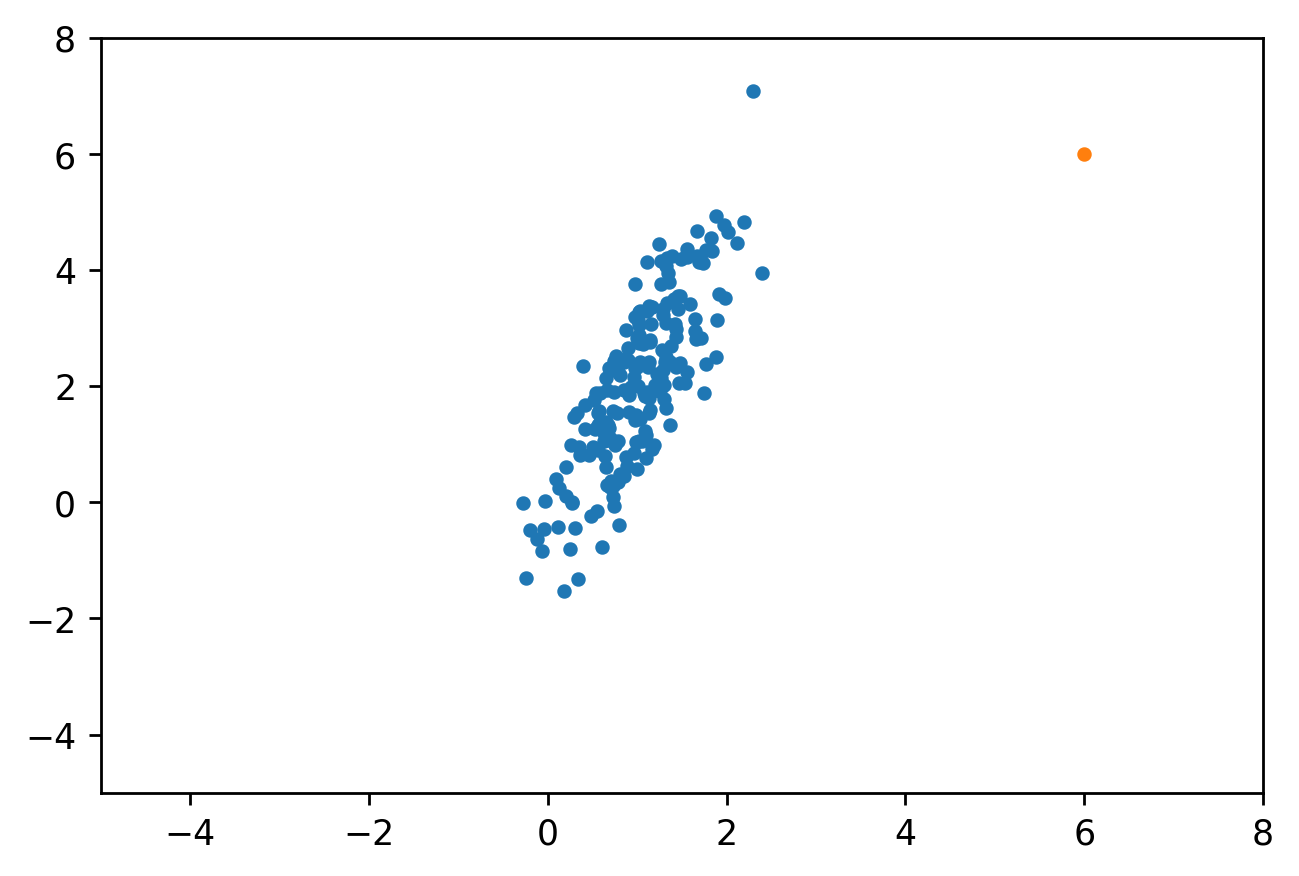

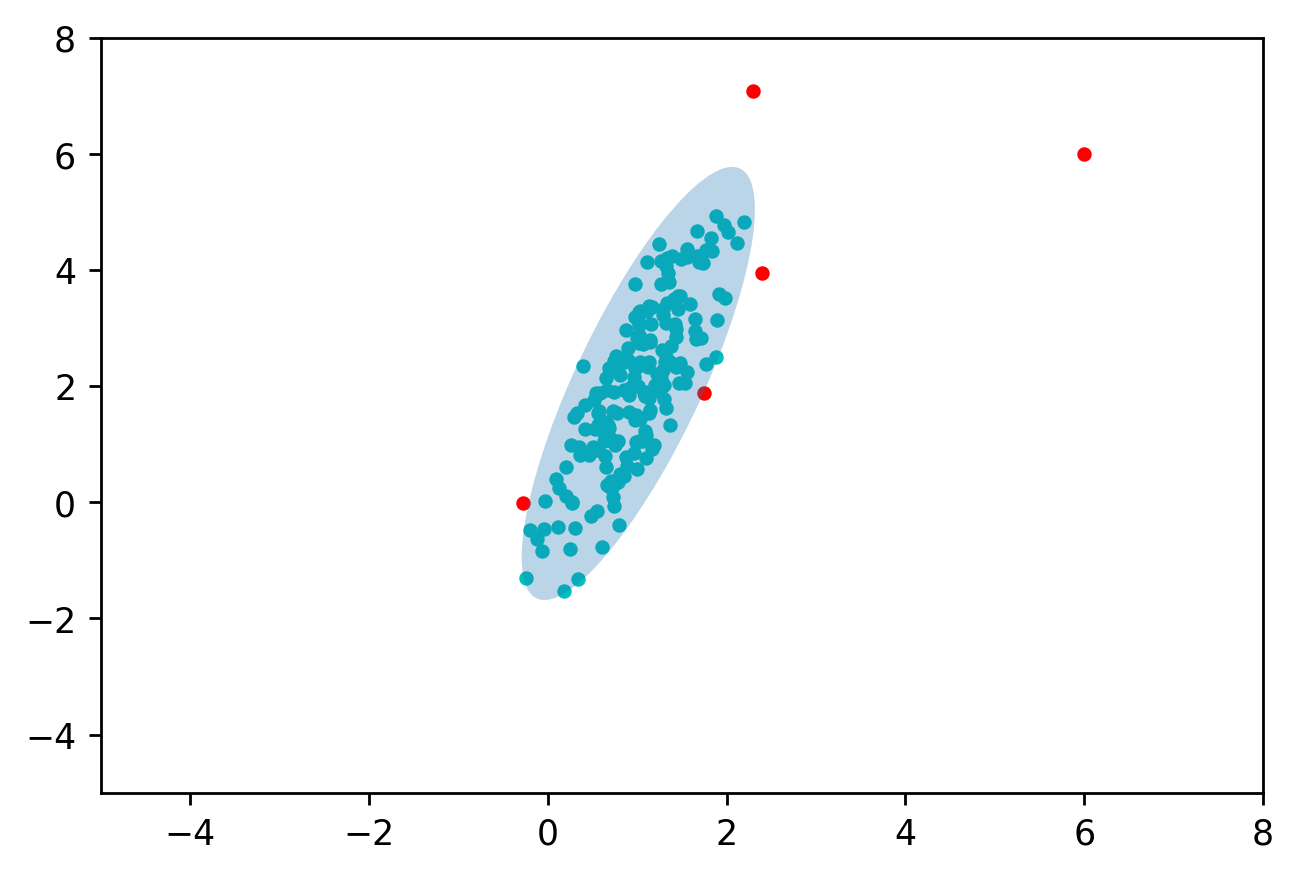

In [12]:
from matplotlib.patches import Ellipse
col1 = np.random.normal(1,0.5,size=200).reshape(-1,1)
col2 = 2*(col1+np.random.normal(0,0.5,size=200).reshape(-1,1))
X = np.hstack((col1,col2))
outlier = np.array([6.,6.]).reshape(-1,2)

plt.figure(dpi=250)
plt.scatter(X[:,0],X[:,1], s=10)
plt.scatter(outlier[:,0],outlier[:,1],s=10)
plt.xlim(-5,8)
plt.ylim(-5,8);
ec = elliptic_covariance(threshold=6.5)
ec.fit(X)
preds = ec.predict(X)

angle = np.arctan(ec.eigenvecs.T[0][1]/ec.eigenvecs.T[0][0]) * 180/np.pi
ell = Ellipse(ec.means, 2*np.sqrt(ec.threshold*ec.eigenvals[0]), 2*np.sqrt(ec.threshold*ec.eigenvals[1]), 
              angle=angle)
ell.set_alpha(0.3)

plt.figure(dpi=250)
for pt,label in zip(X,preds):
    if label > 0:
        plt.scatter(pt[0], pt[1],c='c', s=10)
    else:
        plt.scatter(pt[0], pt[1],c='r',s=10) 
        
for pt,label in zip(outlier,ec.predict(outlier)):
    if label > 0:
        plt.scatter(pt[0], pt[1],c='c',s=10)
    else:
        plt.scatter(pt[0], pt[1],c='r',s=10)  
        
plt.xlim(-5,8)
plt.ylim(-5,8)

ax = plt.gca()
ax.add_artist(ell);

This works by first casting into an eigenspace where the dimensions are along the variation. Let's see the same data but, in the eigenspace

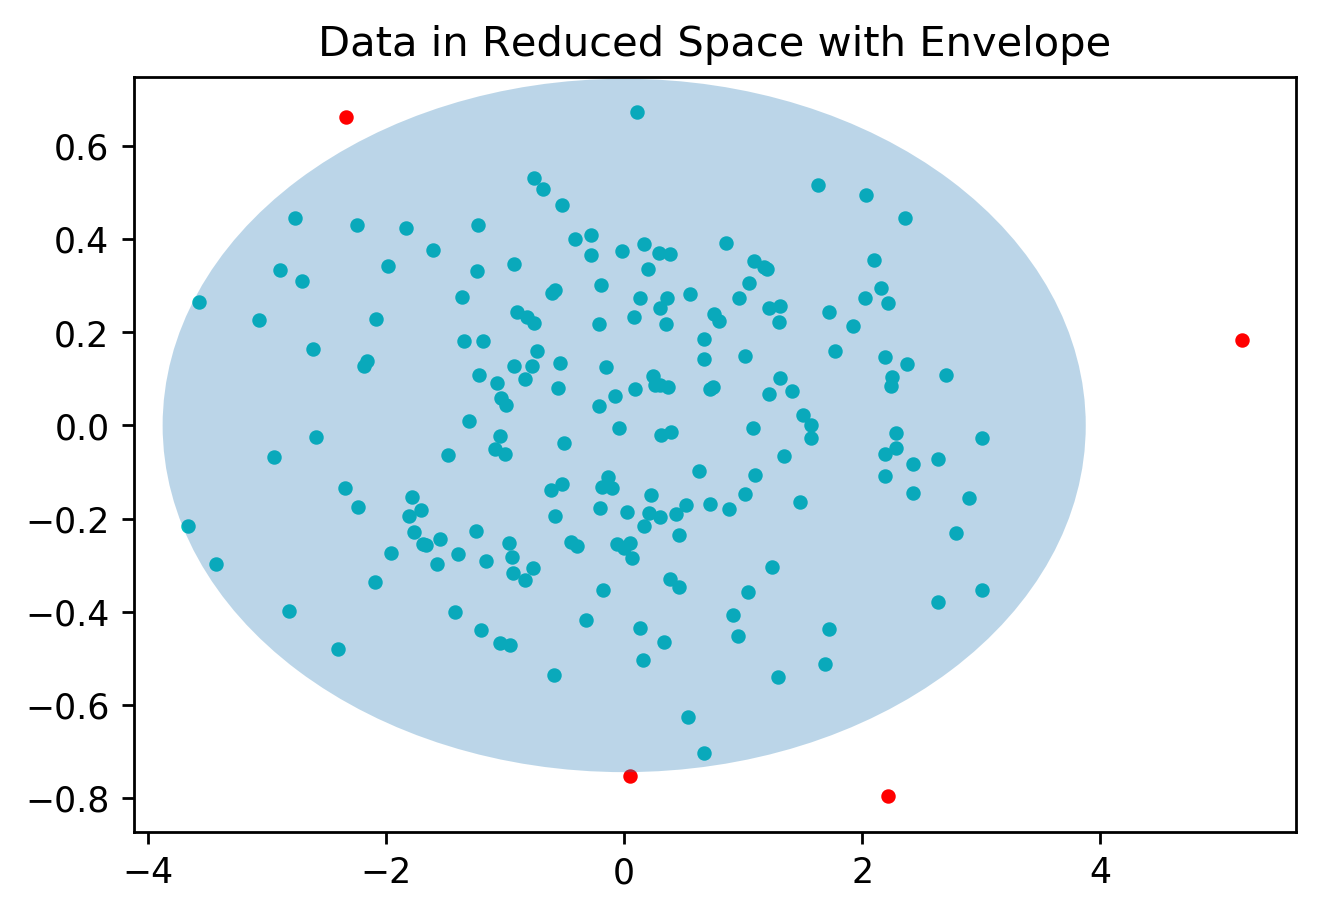

In [13]:
pca_data = ec.convert_to_pca_space(X - ec.means)
ell = Ellipse((0,0), 2*np.sqrt(ec.threshold*ec.eigenvals[0]), 2*np.sqrt(ec.threshold*ec.eigenvals[1]), 
              angle=0)
ell.set_alpha(0.3)

plt.figure(dpi=250)
for pt,label in zip(pca_data,preds):
    if label > 0:
        plt.scatter(pt[0], pt[1],c='c', s=10)
    else:
        plt.scatter(pt[0], pt[1],c='r',s=10) 
plt.title("Data in Reduced Space with Envelope")
ax = plt.gca()
ax.add_artist(ell);

Okay, so that gives us a sense of the problem. We're trying to find ways of deciding "who is in the group" and "who is out of the group." So far, these two simpler methods amount to trying exploit the distribution of the data - after assuming the the mean and standard deviation are representative of the data along each axis (even if the axis has to be found by eigen-decomposition). There are other more advanced methods implemented in SkLearn. Let's take a look at those now.

# Anomaly Detection with SkLearn

First, we want to write a method that allows us to investigate all the different models. This will be the main machinery we use for testing. It accepts a model, generates some data, fits the model, then predicts on all the data, then makes a nice plot for us. 

In [15]:
def outlier_detection(clf, draw_band_thresh=None):
    # Generate train data
    X = 0.3 * rng.randn(100, 2)
    X_train = np.r_[X + 1, X - 1]
    # Generate some regular novel observations
    X = 0.3 * rng.randn(20, 2)
    X_test = np.r_[X + 1, X - 1]
    # Generate some abnormal novel observations
    X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

    # fit the model
    clf.fit(X_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    y_pred_outliers = clf.predict(X_outliers)

    # plot the line, the samples, and the nearest vectors to the plane
    xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(12,10))
    CF = plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
    plt.colorbar(CF)
    
    if not draw_band_thresh:
        b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white',
                         s=40, edgecolor='k')
        b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='magenta',
                         s=40, edgecolor='k')
        c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',
                        s=40, edgecolor='k')
        plt.legend([b1, b2, c],
               ["training observations",
                "new regular observations", "new abnormal observations"],
               loc="upper left", fontsize=16)
    else:
        band_X = xx[(-draw_band_thresh < Z) & (Z < draw_band_thresh)]
        band_y = yy[(-draw_band_thresh < Z) & (Z < draw_band_thresh)]
        ln = plt.scatter(band_X, band_y, marker='*', c='r',s=60)
        plt.legend([ln],['Decision line'], loc="upper left", fontsize=16)
        
    plt.axis('tight')
    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    
    plt.show()
    return clf, X_test, X_outliers

### Isolation Forest

The isolation forest works on the principle that outliers are easier to isolate. We can make a tree by randomly selecting a columns, randomly selecting a split point, and then making the split. If it's truly random, it will be hard to separate things that are alike and easy to separate things that are very different. Isolation Forests, therefore, are looking for points that have very "short" paths to isolation. Let's take a look at the canonical SkLearn example, then extend it a bit.

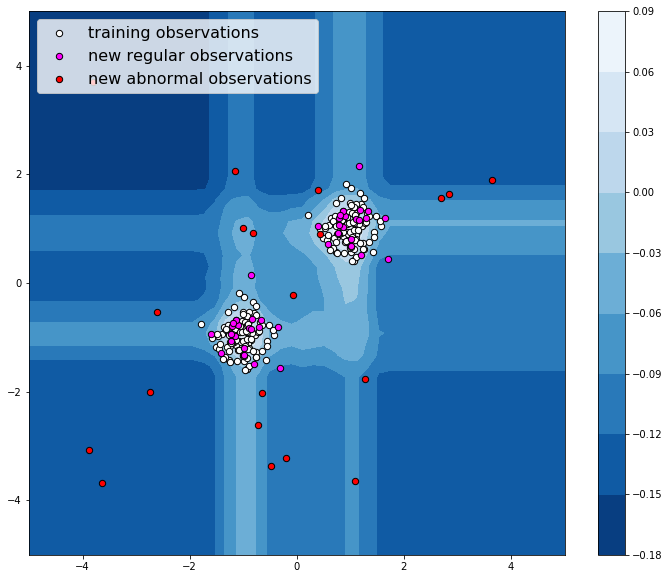

In [16]:
from sklearn.ensemble import IsolationForest
clf, X_test, X_outliers = outlier_detection(IsolationForest(max_samples=100, random_state=rng))

A value of ~0 means it's right on the line between outlier and not. Negative values are outlier regions. So we can see that the main chunk of our "real" points are not-outliers. Nice. Where is the border between outlier and not in our mesh?

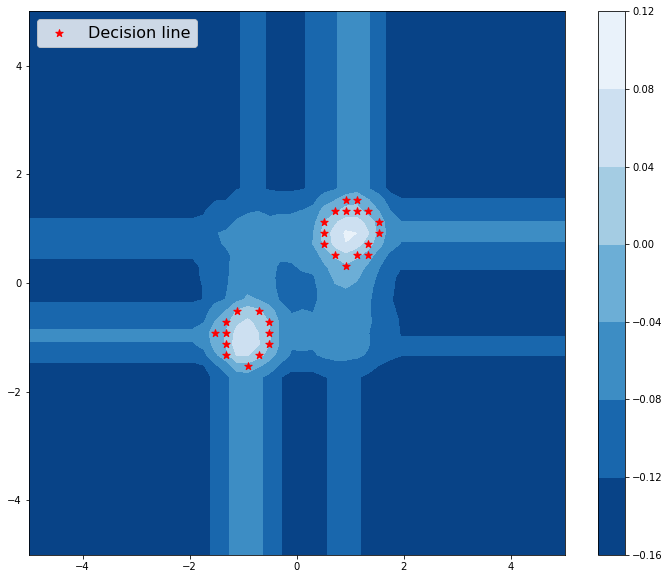

In [17]:
clf, X_test, X_outliers = outlier_detection(IsolationForest(max_samples=100, random_state=rng), draw_band_thresh=0.02)

We can see that outliers are labeled as -1 (not in the class) and inliers are 1 (in the class).

In [18]:
clf.predict(X_test)

array([-1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1])

In [19]:
clf.predict(X_outliers)

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1])

### One Class SVM

One class SVM is another algorithm type. This version tries to draw a soft border around the training data and then evaluates how far any new points are from the boder. If they're inside the border (positive) they are in-class (1). If they're outside (negative) they're out-of-class (-1) 

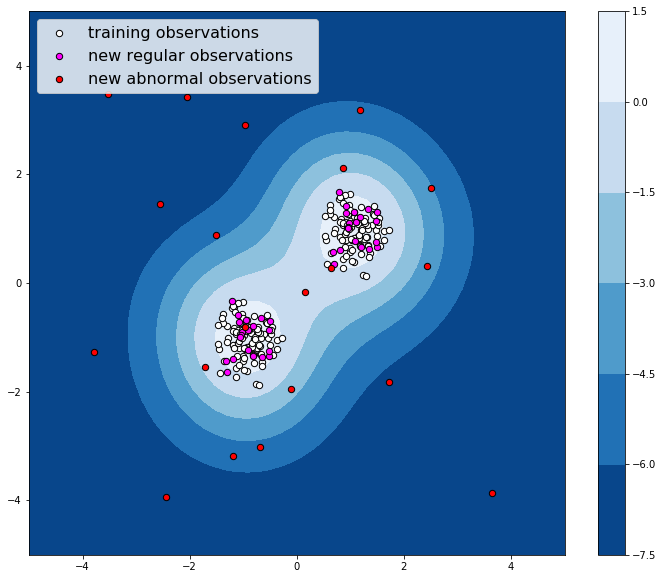

In [20]:
from sklearn.svm import OneClassSVM

clf, X_test, X_outliers = outlier_detection(OneClassSVM(nu=0.1,kernel='rbf'))

In [21]:
clf.predict(X_test)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1, -1])

In [22]:
clf.predict(X_outliers)

array([-1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1])

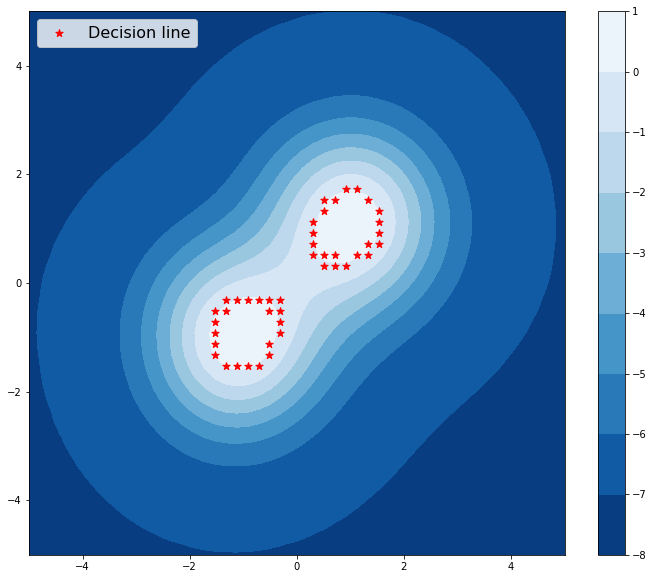

In [23]:
clf, X_test, X_outliers = outlier_detection(OneClassSVM(nu=0.1,kernel='rbf'), draw_band_thresh=0.3)

# Let's try with a real dataset

In [24]:
import pandas as pd
import numpy as np
df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/hypothyroid.data", header=None)

In [25]:
cols = ['target','age','sex','on_thyroxine','query_on_thyroxine','on_antithyroid_medication','thyroid_surgery',
        'query_hypothyroid','query_hyperthyroid','pregnant','sick','tumor','lithium','goitre',
        'TSH_measured','TSH','T3_measured','T3','TT4_measured','TT4','T4U_measured','T4U','FTI_measured',
        'FTI','TBG_measured','TBG']
df.columns = cols

In [26]:
df.target.value_counts(normalize=True)

negative       0.952261
hypothyroid    0.047739
Name: target, dtype: float64

Our data is very unbalanced! We have only 5% of people with hypothyroidism. So we want to take their raw test results and see if we can find out "likely to have hypothyroidism" or "not likely" by playing a game of "is this one like the others?" Let's get started.

In [27]:
X = df

In [28]:
X = X.replace('t',1).replace('f',0)
X.head()

,target,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,...,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG
0,hypothyroid,72,M,0,0,0,0,0,0,0,...,y,0.60,y,15,y,1.48,y,10,n,?
1,hypothyroid,15,F,1,0,0,0,0,0,0,...,y,1.70,y,19,y,1.13,y,17,n,?
2,hypothyroid,24,M,0,0,0,0,0,0,0,...,y,0.20,y,4,y,1,y,0,n,?
3,hypothyroid,24,F,0,0,0,0,0,0,0,...,y,0.40,y,6,y,1.04,y,6,n,?
4,hypothyroid,77,M,0,0,0,0,0,0,0,...,y,1.20,y,57,y,1.28,y,44,n,?


In [29]:
X['TSH'] = X['TSH'].replace('?','0').astype(float)
X['T3'] = X['T3'].replace('?','0').astype(float)
X['TT4'] = X['TT4'].replace('?','0').astype(float)
X['T4U'] = X['T4U'].replace('?','0').astype(float)
X['TBG'] = X['TBG'].replace('?','0').astype(float)
X['FTI'] = X['FTI'].replace('?','0').astype(float)

In [30]:
to_drop = [x for x in df.columns if "_measured" in x]
X = X.drop(to_drop, axis=1)

In [31]:
X['age'] = X['age'].replace('?',np.nan)
X['sex'] = X['sex'].replace('F',1).replace('M',0).replace('?',np.nan)
X = X.rename(columns={'sex':'female'})

In [32]:
final_X = X.dropna()

In [33]:
final_X.loc[:,'age'] = final_X['age'].astype(int)

/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [34]:
final_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2700 entries, 0 to 3162
Data columns (total 20 columns):
target                       2700 non-null object
age                          2700 non-null int64
female                       2700 non-null float64
on_thyroxine                 2700 non-null int64
query_on_thyroxine           2700 non-null int64
on_antithyroid_medication    2700 non-null int64
thyroid_surgery              2700 non-null int64
query_hypothyroid            2700 non-null int64
query_hyperthyroid           2700 non-null int64
pregnant                     2700 non-null int64
sick                         2700 non-null int64
tumor                        2700 non-null int64
lithium                      2700 non-null int64
goitre                       2700 non-null int64
TSH                          2700 non-null float64
T3                           2700 non-null float64
TT4                          2700 non-null float64
T4U                          2700 non-null float64


In [35]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

y = final_X.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(final_X, y, test_size=0.2, stratify=y, random_state=75)

in_class_X_train = X_train[X_train['target']=='negative']
iso = IsolationForest(n_estimators=1000, n_jobs=-1, max_features=0.2, bootstrap=True)
iso.fit(in_class_X_train.iloc[:,1:])

IsolationForest(bootstrap=True, contamination=0.1, max_features=0.2,
        max_samples='auto', n_estimators=1000, n_jobs=-1,
        random_state=None, verbose=0)

In [36]:
y_test = y_test.replace('negative',1).replace('hypothyroid',-1)
y_test.value_counts()

 1    513
-1     27
Name: target, dtype: int64

In [37]:
def score(model, X_test, y_test):
    preds = model.predict(X_test)
    y_test = y_test.replace('negative',1).replace('hypothyroid',-1)

    yeps = 0
    total = 0
    yeps_on_outliers = 0
    yeps_on_inliers = 0
    num_outliers = 0
    num_inliers = 0
    for true, pred in zip(y_test, preds):
        if true == pred:
            yeps += 1
            if true == -1:
                yeps_on_outliers += 1
            else:
                yeps_on_inliers += 1
        if true == -1:
            num_outliers +=1
        else:
            num_inliers += 1
        total += 1

    print("Total Accuracy: ", yeps/total)
    print("Outlier Accuracy: ", yeps_on_outliers/num_outliers)
    print("Inlier Accuracy: ", yeps_on_inliers/num_inliers)
    

In [38]:
score(iso, X_test.iloc[:,1:], y_test)

Total Accuracy:  0.8962962962962963
Outlier Accuracy:  0.7407407407407407
Inlier Accuracy:  0.9044834307992202


With almost no real thought into the feature selection, just taking the raw measurements from the patient, we can correctly identify almost 77% of true outliers (cases of hypothyroidism). We also only incorrectly mark someone as an outlier 10% of the time. That's not too bad. Let's see if we can do better with one-class SVC.

In [39]:
from sklearn.svm import OneClassSVM

X_tuning, X_test_2, y_tuning, y_test_2 = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=75)

for nu_val in np.linspace(0.001,0.999,20):
    print("--- nu = %f ---\n"%nu_val)
    ocsvm = OneClassSVM(nu=nu_val,kernel='linear')
    ocsvm.fit(X_tuning.iloc[:,1:])
    score(ocsvm, X_test_2.iloc[:,1:], y_test_2)
    print("\n")

--- nu = 0.001000 ---

Total Accuracy:  0.9467592592592593
Outlier Accuracy:  0.045454545454545456
Inlier Accuracy:  0.9951219512195122


--- nu = 0.053526 ---

Total Accuracy:  0.9120370370370371
Outlier Accuracy:  0.18181818181818182
Inlier Accuracy:  0.9512195121951219


--- nu = 0.106053 ---

Total Accuracy:  0.8796296296296297
Outlier Accuracy:  0.22727272727272727
Inlier Accuracy:  0.9146341463414634


--- nu = 0.158579 ---

Total Accuracy:  0.8587962962962963
Outlier Accuracy:  0.5909090909090909
Inlier Accuracy:  0.8731707317073171


--- nu = 0.211105 ---

Total Accuracy:  0.8379629629629629
Outlier Accuracy:  0.7272727272727273
Inlier Accuracy:  0.8439024390243902


--- nu = 0.263632 ---

Total Accuracy:  0.7824074074074074
Outlier Accuracy:  0.9545454545454546
Inlier Accuracy:  0.7731707317073171


--- nu = 0.316158 ---

Total Accuracy:  0.75
Outlier Accuracy:  0.9545454545454546
Inlier Accuracy:  0.7390243902439024


--- nu = 0.368684 ---

Total Accuracy:  0.7152777777777778

In [40]:
for nu_val in np.linspace(0.2,0.28,20):
    print("--- nu = %f ---\n"%nu_val)
    ocsvm = OneClassSVM(nu=nu_val,kernel='linear')
    ocsvm.fit(X_tuning.iloc[:,1:])
    score(ocsvm, X_test_2.iloc[:,1:], y_test_2)
    print("\n")

--- nu = 0.200000 ---

Total Accuracy:  0.8449074074074074
Outlier Accuracy:  0.7272727272727273
Inlier Accuracy:  0.8512195121951219


--- nu = 0.204211 ---

Total Accuracy:  0.8402777777777778
Outlier Accuracy:  0.7272727272727273
Inlier Accuracy:  0.8463414634146341


--- nu = 0.208421 ---

Total Accuracy:  0.8402777777777778
Outlier Accuracy:  0.7272727272727273
Inlier Accuracy:  0.8463414634146341


--- nu = 0.212632 ---

Total Accuracy:  0.8356481481481481
Outlier Accuracy:  0.8181818181818182
Inlier Accuracy:  0.8365853658536585


--- nu = 0.216842 ---

Total Accuracy:  0.8333333333333334
Outlier Accuracy:  0.8181818181818182
Inlier Accuracy:  0.8341463414634146


--- nu = 0.221053 ---

Total Accuracy:  0.8310185185185185
Outlier Accuracy:  0.8181818181818182
Inlier Accuracy:  0.8317073170731707


--- nu = 0.225263 ---

Total Accuracy:  0.8194444444444444
Outlier Accuracy:  0.8636363636363636
Inlier Accuracy:  0.8170731707317073


--- nu = 0.229474 ---

Total Accuracy:  0.810185

With a `linear` kernel and a nu-value of "0.237895" we seem to be getting our best values. So let's see how that behaves given the whole training set.

In [41]:
final_model = OneClassSVM(nu=0.237895,kernel='linear')
final_model.fit(X_train.iloc[:,1:], y_train)
score(final_model, X_test.iloc[:,1:], y_test)

Total Accuracy:  0.8074074074074075
Outlier Accuracy:  0.9629629629629629
Inlier Accuracy:  0.7992202729044834


**Not Bad!** We get 96% of all outliers and still only have a false positive rate of 20% for people without hypothyroidism. That's workable!